# 机器学习Lab1——基于KNN 的手写数字识别
- 姓名：吴静
- 学号：2113285
- 班级：信息安全二班





## 实验要求
实验条件：给定semeion手写数字数据集，给定kNN分类算法

实验要求：
1. 基本要求：编程实现kNN算法；给出在不同k值（1，3，5）情况下，KNN算法对手写数字的识别精度（要求采用留一法）
2. 中级要求：与weka机器学习包中的KNN分类结果进行对比（本次实验选择sklearn）
3. 提高要求：采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别

## 导入需要的包

In [1]:
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import imgaug as ia
import imgaug.augmenters as iaa
from keras import models
from keras import layers
import cv2
import matplotlib.pyplot as plt

E:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## 导入数据集semesion

In [2]:
def data_in(filename):
    f=open(filename)
    content=f.readlines()#将结果存储于一个列表中，行数即列表元素个数
    line_num=len(content)#获取列表元素个数即行数
    f.close()
    #初始化
    Map=[]#存储所有行数中除了每行最后十个以外的数，特征矩阵
    Vector=[]#存储每行最后十个中第一个1所在的位置，类别向量
    for i in range(line_num):#每一行遍历
        train_temp=[]#每一行的所有训练元素
        temp=content[i].split()#temp是一个列表，其中有每一行的所有元素

        for m in temp[:-10]:
            m=float(m)
            train_temp.append(m)#没有序号要求，直接加在后面就可以
        Map.append(train_temp)
        
        num=0
        for m in temp[-10:]:
            if m != '1':
                #别忘了“：”
                #这里1是字符！！
                num+=1.0#字符1的个数
            else:
                break
        Vector.append(num)
    Vector=np.array(Vector)
    Map=np.array(Map)
    return Map,Vector

In [3]:
X,Y=data_in('semeion.data')
np.shape(X),np.shape(Y)

((1593, 256), (1593,))

In [4]:
print(X)
#若X是列表则会全部输出
#若X是np数组则会折叠输出，如下所示

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
print(Y)

[0. 0. 0. ... 9. 9. 9.]


## 实验背景
k折交叉检验：
<br>将训练集划分为k份，并依次选择其中的⼀份作为测试集，其他作为训练集。
<br><br>留一法：
<br>令K折交叉检验方法的K等于数据集大小,即只留一个数据样本作为测试集,其余都为训练集.计算平均准确率.

## KNN实验思路
1. 总共有多少个数据，就需要进行多少次循环，每个循环里面都会根据当前训练集判断测试集，然后检测当前判断得出的测试集的结果和他实际的标签是否一样。若是一样，则精确度+1，反之不变化。
2. 测试集与训练集的划分：测试集依次选取，训练集是总数据集中除去测试集之外的那些数据集（用到delete函数）
3. 距离的求取：每一次都计算测试集与每个训练集之间的距离，采用欧几里得算法：差值平方和的开方。
4. 由KNN算法得，需要求出距离最近的k个值（用到排序）
5. 统计（Counter）这k个值中哪一个的标签最多（此时需要注意一种情况，即有几个标签同时最多的情况，这里需要在most_common中体现）
6. 由KNN算法，标签最多的那个标签即为测试集的标签，此时与测试集所对应的标签作比较，如果相同，则正确判断数+1。
7. 计算正确率：由前文分析可知，已经求出了正确判断数，由于总共判断了（数据集的个数）次，于是总共的判断数即为数据集的个数。

## 基本要求
编程实现KNN算法，使用留一法，给出在不同k值（1，3，5）情况下，KNN算法对手写数字的识别精度 

In [6]:
def Knn(data_X, data_Y, k):
    #data_X特征
    #data_Y标签
    num_samples=data_X.shape[0]
    #要分成几次（总共会有num_samples个测试集，每一个数据都会成为测试集一次）
    right_judge=0
    #在那些测试中，总共成功了的次数
    
    for r in range(num_samples):
        X_test = data_X[r]
        Y_test = data_Y[r]
        #按顺序选取一个测试集
        X_train = np.delete(data_X, r, axis=0)
        Y_train = np.delete(data_Y, r, axis=0)
        #除去分离的测试集，剩下的都是训练集
        #X_train训练集特征数据
        #X_test测试集特征数据
        #Y_train训练集目标数据
        #Y_test测试集目标数据
        
        train_num=X_train.shape[0]
        #训练集的大小
        distances=[]
        #测试集和各个训练集的欧几里得距离的集合
        labels=[]
        #对应标签
        first_k_label=[]
        #前k个小距离对应的训练集标签
        
        for i in range(train_num):
            sub=X_test-X_train[i]
            #减
            squared=np.square(sub)
            sum_result=np.sum(squared)
            #axis默认为none，表示对整个矩阵进行求和
            #axis=0表示按列方向进行操作
            #axis=1表示按行方向进行操作
            #此时sum_result和squared的行列数相同
            sqrt_result=np.sqrt(sum_result)
            #进行开方操作
            distances.append(sqrt_result)
            labels.append(Y_train[i])
        sort_index_result=np.argsort(distances)
        #升序排序的索引。即升序排列时原数组索引是多少
        #sort_result=np.sort(sqrt_result,axis=0)[::-1]表示降序排序
        for j in range(k):
            first_k_label.append(Y_train[sort_index_result[j]])
            #sort_index_result[j]:从最短距离开始取，在原数组中是几号
            #range(k):取k个从小到大的最短距离
            #Y_train:这个距离对应的标签
            #Y_train[j] 表示训练集中的第 j 个样本的目标值（标签）
            #Y_train[j][0] 表示训练集中第 j 个样本的目标值的第一个元素
            #在大多数情况下，目标值是一个标量
            #因此 Y_train[j][0] 将直接对应于第 j 个样本的标签
        count=Counter(first_k_label)
        #Counter(labelCount) 是用于创建一个计数器对象的语句
        #用于计算可迭代对象中每个元素的出现次数，并将结果存储为一个字典
        #其中键是标签，值是标签出现的次数
        first_two=count.most_common(2)[0][0]
        #使用 most_common() 方法获取出现次数最多的前两个标签以及它们的出现次数
        #返回一个列表，其中包含元组 (标签, 出现次数)，按照出现次数从大到小排序
        #[0][0] 用于获取列表中的第一个元组，即出现次数最多的标签和它的出现次数
        if first_two==Y_test:
            right_judge+=1
    accuracy=right_judge/num_samples
    print("k=",k,"时，判断正确个数:",right_judge,"个，总共有:",num_samples,"个样本（训练了",num_samples,"次），识别正确率：",accuracy)
    return accuracy

实验结果：

In [7]:
Knn(X,Y,1)
Knn(X,Y,3)
Knn(X,Y,5)

k= 1 时，判断正确个数: 1459 个，总共有: 1593 个样本（训练了 1593 次），识别正确率： 0.9158819836785939
k= 3 时，判断正确个数: 1464 个，总共有: 1593 个样本（训练了 1593 次），识别正确率： 0.9190207156308852
k= 5 时，判断正确个数: 1458 个，总共有: 1593 个样本（训练了 1593 次），识别正确率： 0.9152542372881356


0.9152542372881356

## 中级要求
与sklearn机器学习包中的kNN分类结果进行对比

In [8]:
def knn_sklearn(X,Y,k):
    num_samples=X.shape[0]
    accu=[]
    for r in range(num_samples):
        X_test = [X[r]]
        Y_test = Y[r]
        #按顺序选取一个测试集
        X_train = np.delete(X, r, axis=0)
        Y_train = np.delete(Y, r, axis=0)
        #除去分离的测试集，剩下的都是训练集
        #X_train训练集特征数据
        #X_test测试集特征数据
        #Y_train训练集目标数据
        #Y_test测试集目标数据
        
        X_test=np.array(X_test)
        Y_test=np.array(Y_test)
        knn_classifier=KNeighborsClassifier(n_neighbors=k)
        #实例化KNN模型
        knn_classifier.fit(X_train,Y_train)
        #放入训练数据进行训练
        Y_pred=knn_classifier.predict(X_test)
        #预测内容
        accuracy=accuracy_score([Y_test],[Y_pred])
        accu.append(accuracy)
    print("k=",k,"时，sklearn判断正确个数:",np.sum(accu),"个，总共有:",num_samples,"个样本（训练了",num_samples,"次），识别正确率：",np.sum(accu)/num_samples)

In [9]:
knn_sklearn(X,Y,1)
knn_sklearn(X,Y,3)
knn_sklearn(X,Y,5)

k= 1 时，sklearn判断正确个数: 1461.0 个，总共有: 1593 个样本（训练了 1593 次），识别正确率： 0.9171374764595104
k= 3 时，sklearn判断正确个数: 1439.0 个，总共有: 1593 个样本（训练了 1593 次），识别正确率： 0.9033270558694287
k= 5 时，sklearn判断正确个数: 1439.0 个，总共有: 1593 个样本（训练了 1593 次），识别正确率： 0.9033270558694287


## 提高要求
采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别)

在Python中，数据扩充是通过对原始数据应用一系列变换或增强技术来生成更多的样本，包括翻转、旋转、尺度变换、随机抠取、色彩抖动等。这些方法可以应用于各种类型的数据，包括图像、文本、时间序列等。
本次实验使用imgaug进行图像增强。

In [10]:
X,Y=data_in('semeion.data')
#加载原始数据

intense= iaa.Sequential([
    iaa.Affine(rotate=(-10,10)),  # 添加各种增强操作
    iaa.Affine(rotate=(0.8,1.2)),  # 添加其他增强操作
    # ...
])

# seq = iaa.Sequential([
#     iaa.SomeAugmentation(),  # 添加各种增强操作
#     iaa.AnotherAugmentation(),  # 添加其他增强操作
#     # ...
# ])
#使用 iaa.Affine(rotate=degrees) 来表示旋转操作
#其中 degrees 是旋转的角度（以度为单位）
#这个值可以是一个数值，也可以是一个范围，用于表示随机旋转的角度。
#使用 iaa.Resize(scale) 来表示缩放操作,scale 是缩放因子


数据进行增强后，我们需要对数据进行变换，使之满足CNN的输入数据要求，具体表现为：

1.**图像大小一致性**：在训练 CNN 模型时，输入图像的大小通常需要保持一致。这是因为卷积层和池化层等层次的结构期望输入数据具有相同的维度。在代码中，使用 cv2.resize 函数将增强后的图像调整为相同的期望大小 (16, 16)。

2.**四维输入**：CNN 的输入数据通常是四维的，具体要求为 (Batch Size, Height, Width, Channels)。在代码中，通过 X_train = X_train.reshape(-1, 16, 16, 1) 和 X_test = X_test.reshape(-1, 16, 16, 1) 将输入数据的形状调整为四维，其中 Batch Size 表示样本数量，Height 和 Width 表示图像的高度和宽度，Channels 表示通道数，通常为 1（灰度图像）或 3（彩色图像）。

3.**标签数据一致性**：输入数据的标签数据也需要与输入数据一致。在代码中，通过 Y = Y.reshape(-1, 1) 将标签数据的形状调整为 (Batch Size, 1)，以确保标签与输入数据匹配。

In [11]:
expected_shape=(16,16)

X_all=[]
#存储每个数据增强后的图像

for image in X:
    augmented_image = intense.augment_image(image.reshape(16,16))
    #使用增强序列将增强操作应用到图像数据上。
    
    augmented_image=cv2.resize(augmented_image,expected_shape)
    #cv2.resize 函数被用于将 augmented_img 调整为指定的 expected_shape，这里是 (16, 16) 像素。
    #这个函数会将图像按照指定的大小进行缩放或拉伸，以适应新的大小,以便输入到卷积神经网络（CNN）中
    
    X_all.append(augmented_image.flatten())
    #将二维的图像数组转换成一维的向量，以便它们可以作为特征输入到卷积神经网络（CNN）模型中。
    
X_all=np.array(X_all)
#转化为np数组

# 将 Y 的形状从 (1593,) 转换为 (1593, 1)
Y = Y.reshape(-1, 1)

# 合并原始数据和增强数据
X_combined = np.vstack((X, X_all))
Y_combined = np.vstack((Y, Y))
#vstack()用于垂直（按行）堆叠多个数组

# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y_combined, test_size=0.2, random_state=42)

# 将输入数据的形状调整为 (None, 16, 16, 1)
X_train = X_train.reshape(-1, 16, 16, 1)
X_test = X_test.reshape(-1, 16, 16, 1)


接下来构建一个CNN模型：

In [12]:
# 创建一个顺序模型
model = models.Sequential()

# 添加卷积层
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 1)))  # 输入形状根据图像大小和通道数调整

# 添加最大池化层
model.add(layers.MaxPooling2D((2, 2)))

# 添加另一个卷积层
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# 添加另一个最大池化层
model.add(layers.MaxPooling2D((2, 2)))

# 添加全连接层
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# 输出层
model.add(layers.Dense(10, activation='softmax'))  
# 假设有10个类别，通常用于分类问题的输出层激活函数是 softmax


接下来编译模型：

In [13]:
# 编译模型
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#损失函数选择sparse_categorical_crossentropy ；
#优化器选择adam

接下来训练模型：

In [14]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2)
#训练模型
#validation_split（验证集划分比例）:表示从训练数据中分割出的验证集的比例
#epochs 指定了模型在整个训练数据集上训练的次数
#batch_size 决定了每个训练迭代中用于更新模型权重的样本数量

Epoch 1/10
32/32 [==============================] - 1s 12ms/step - loss: 2.0114 - accuracy: 0.3862 - val_loss: 1.5654 - val_accuracy: 0.5059
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 1.0688 - accuracy: 0.6958 - val_loss: 0.8632 - val_accuracy: 0.7529
Epoch 3/10
32/32 [==============================] - 0s 7ms/step - loss: 0.6805 - accuracy: 0.7900 - val_loss: 0.6588 - val_accuracy: 0.8000
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 0.5234 - accuracy: 0.8400 - val_loss: 0.5574 - val_accuracy: 0.8314
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.4327 - accuracy: 0.8724 - val_loss: 0.5072 - val_accuracy: 0.8431
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.3504 - accuracy: 0.8970 - val_loss: 0.4226 - val_accuracy: 0.8627
Epoch 7/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2955 - accuracy: 0.9156 - val_loss: 0.3560 - val_accuracy: 0.8922
Epoch 8/10
32/32 [=

接下来评估模型：

In [15]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
#评估模型

20/20 [==============================] - 0s 3ms/step - loss: 0.2208 - accuracy: 0.9357


可视化训练历史，使用图形库（这里使用的是Matplotlib）进行可视化：

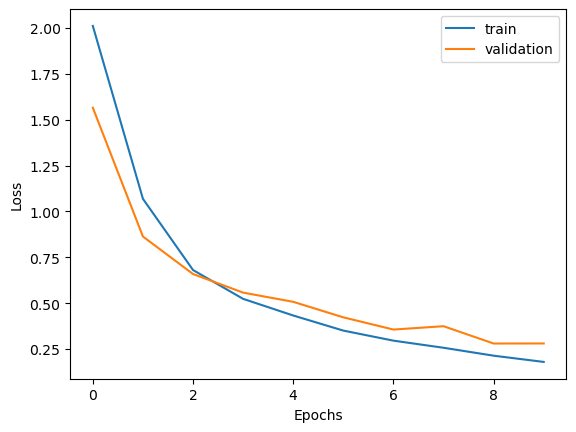

In [16]:
# 绘制训练和验证的损失曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#可视化训练历史